<h1><span style="background-color:blue; color:white; padding: 5px;">Entrainment de modèles avec RandomForest Regressor<br></h1>
</h4><span style="background-color:red; color:white; padding: 5px;">Utiliser un outil permettant de rafraîchir la page régulièrement pour éviter la mise en sommeil de MLflow sur Heroku
</span></h4>

In [4]:
import pandas as pd
from functions2 import *

### Choix du type de bien à entraîner

In [5]:
type_de_bien = "Maison"

### Chargement des données

In [14]:
query=f"""
SELECT 
    V.SURFACE_BATI,
    V.DEPENDANCES,
    V.ID_COMMUNE,
    R.Name_region,
    {'V.SURFACE_TERRAIN,' if type_de_bien=="Maison" else ''}
    V.DATE_MUTATION,
    V.MONTANT
FROM VENTES V
INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
WHERE V.MONTANT>15000
AND T.NAME_TYPE_BIEN='{type_de_bien}'
AND V.SURFACE_BATI>0
AND V.NB_PIECES>0
# AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
"""

df = loading_data(query)
print(f"Les données s'étendent du {df['DATE_MUTATION'].min()} au {df['DATE_MUTATION'].max()}")
print(f"Il y a {df.shape[0]} ventes sur cette durée.")
print("Voici un aperçue des données :")
df.head()

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Les données s'étendent du 2021-09-30 00:00:00 au 2022-12-31 00:00:00
Il y a 494173 ventes sur cette durée.
Voici un aperçue des données :


,SURFACE_BATI,DEPENDANCES,ID_COMMUNE,Name_region,DATE_MUTATION,MONTANT
0,61,0,07116,Auvergne-Rhône-Alpes,2021-12-03,35000
1,90,1,07019,Auvergne-Rhône-Alpes,2021-12-01,100000
2,61,1,07331,Auvergne-Rhône-Alpes,2021-12-03,89000
3,104,1,07116,Auvergne-Rhône-Alpes,2021-11-26,210000
4,49,0,07010,Auvergne-Rhône-Alpes,2021-12-09,35000


### Splittage

In [7]:
X_train,y_train, X_test, y_test = split(df)

Split des données en cours...
Split OK


### Labellisation, standardisation

In [8]:
X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

Normalisation des données en cours...
Normalisation des données OK


### Entraînement du modèle

In [9]:
# Configuration du modèle
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
    }   
cv=5

In [10]:
model, best_params = train_model_randomforest(X_train,y_train, param_grid, cv)

Entraînement en cours ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.5min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.4min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.5min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.5min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.5min
Ré-entraînement avec les meilleurs hyperparamètres en cours...
Entraînement OK


### Sauvegarde avec MLflow

In [11]:
# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor_all_datas_region_time"
run_name = type_de_bien
model_name = f"RFR_all_datas_{type_de_bien}"

Tracé du graphique en cours...


Itération N°1 : train score = 0.6781267473751326 -- validation score = -0.18518465766893666
Itération N°2 : train score = 0.40268379422984957 -- validation score = 0.11936848523718502
Itération N°3 : train score = 0.3758477067835241 -- validation score = 0.13821787544483188
Itération N°4 : train score = 0.33053412126307913 -- validation score = 0.14426082396832163
Itération N°5 : train score = 0.4147193985432698 -- validation score = 0.06909335856122178
Itération N°6 : train score = 0.30197287042603294 -- validation score = 0.13659223011613675
Itération N°7 : train score = 0.32069217981537657 -- validation score = 0.0981460080090032
Itération N°8 : train score = 0.30708051186005836 -- validation score = 0.23533460700835984
Itération N°9 : train score = 0.2473896731477755 -- validation score = 0.25001522613358795
Itération N°10 : train score = 0.22705539960237153 -- validation score = 0.22761374854018612


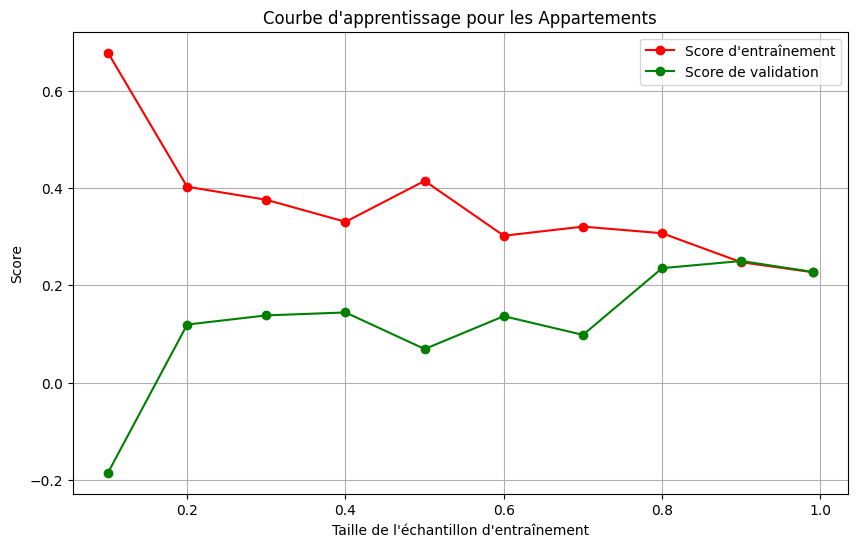

Tracé OK


In [12]:
# Tracé et enregistrement de la learning curve
image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)

In [15]:
log_mlflow(uri_tracking,
           experiment_name, run_name,
            best_params,
            model, model_name,
            X_test, y_test,
            encoders,scalers,
            image_path)

Log du modèle et des artifacts en cours...


KeyboardInterrupt: 

<h2><span style="background-color:red; color:white; padding: 5px;">Entraînement sur 12 mois et test sur les 3derniers mois</span></h2>

In [ ]:
# Configuration du modèle
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
    }   
cv=5

# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor_15months_all_datas_region"

for type_de_bien in ["Maison","Appartement"] :

    run_name = type_de_bien
    model_name = f"RFR_all_datas_{type_de_bien}"
    
    query=f"""
    SELECT 
        V.SURFACE_BATI,
        V.DEPENDANCES,
        V.ID_COMMUNE,
        R.Name_region,
        {'V.SURFACE_TERRAIN,' if type_de_bien=="Maison" else ''}
        V.DATE_MUTATION,
        V.MONTANT
    FROM VENTES V
    INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
    INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
    INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
    INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
    WHERE V.MONTANT>15000
    AND T.NAME_TYPE_BIEN='{type_de_bien}'
    AND V.SURFACE_BATI>0
    AND V.NB_PIECES>0
    AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
    AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
    """

    df = loading_data(query)
    print(f"Les données s'étendent du {df['DATE_MUTATION'].min()} au {df['DATE_MUTATION'].max()}")
    print(f"Il y a {df.shape[0]} ventes sur cette durée.")
    print("Voici un aperçue des données :")
    
    X_train,y_train, X_test, y_test = split(df)

    X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

    model, best_params = train_model_randomforest(X_train,y_train, param_grid, cv)

    # Tracé et enregistrement de la learning curve
    image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)
    
    log_mlflow(uri_tracking,
           experiment_name, run_name,
            best_params,
            model, model_name,
            X_test, y_test,
            encoders,scalers,
            image_path)

<h2><span style="background-color:red; color:white; padding: 5px;">Un modèle par type de bien et par région avec entraînement sur 12 mois et test sur 3 mois</span></h2>

In [ ]:
# Configuration du modèle
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
    }   
cv=5

# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor_15months_region"

for region in df['Name_region'].unique():
    print(region)
    for type_de_bien in ["Maison","Appartement"] :

        run_name = type_de_bien+region
        model_name = f"RFR_all_datas_{type_de_bien}"
        
        query=f"""
        SELECT 
            V.SURFACE_BATI,
            V.DEPENDANCES,
            V.ID_COMMUNE,
            R.Name_region,
            {'V.SURFACE_TERRAIN,' if type_de_bien=="Maison" else ''}
            V.DATE_MUTATION,
            V.MONTANT
        FROM VENTES V
        INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
        INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
        INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
        INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
        WHERE V.MONTANT>15000
        AND Name_region='{region}
        AND T.NAME_TYPE_BIEN='{type_de_bien}'
        AND V.SURFACE_BATI>0
        AND V.NB_PIECES>0
        AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
        AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
        """

        df = df.drop(columns=['Name_region'])

        df = loading_data(query)
        print(f"Les données s'étendent du {df['DATE_MUTATION'].min()} au {df['DATE_MUTATION'].max()}")
        print(f"Il y a {df.shape[0]} ventes sur cette durée.")
        print("Voici un aperçu des données :")
        
        X_train,y_train, X_test, y_test = split(df)

        X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

        model, best_params = train_model_randomforest(X_train,y_train, param_grid, cv)

        # Tracé et enregistrement de la learning curve
        image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)
        
        log_mlflow(uri_tracking,
            experiment_name, run_name,
                best_params,
                model, model_name,
                X_test, y_test,
                encoders,scalers,
                image_path)